In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
import random
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Função para aplicar SpecAugment
def spec_augment(mfccs, time_mask_param=10, freq_mask_param=5):
    # Máscara de tempo
    time_mask = np.random.randint(0, time_mask_param)
    mfccs[:, time_mask:time_mask + np.random.randint(0, time_mask_param)] = 0

    # Máscara de frequência
    freq_mask = np.random.randint(0, freq_mask_param)
    mfccs[freq_mask:freq_mask + np.random.randint(0, freq_mask_param), :] = 0

    return mfccs

# Função para extrair MFCCs do áudio
def extract_features(y, sr):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Retorna a média dos coeficientes
    except Exception as e:
        print(f"Erro ao extrair MFCCs: {e}")
        return None

# Função para carregar dados e aplicar SpecAugment
def load_data_with_spec_augment(folder_path, label):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Extrair features do áudio original
            features = extract_features(y, sr)
            if features is not None:
                data.append(features)
                labels.append(label)

            # Aplicar SpecAugment
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs_augmented = spec_augment(mfccs)
            features_augmented = np.mean(mfccs_augmented.T, axis=0)

            if features_augmented is not None:
                data.append(features_augmented)
                labels.append(label)

        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

    return data, labels

In [ ]:
# Definir caminhos dos áudios
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

# Criar diretórios se não existirem
os.makedirs(file_path_real, exist_ok=True)
os.makedirs(file_path_fake, exist_ok=True)

# Carregar dados com ruído
data_real, labels_real = load_data_with_spec_augment(file_path_real, label=1)  # Áudios reais
data_fake, labels_fake = load_data_with_spec_augment(file_path_fake, label=0)  # Áudios falsos

# Unir dados reais e falsos
data = data_real + data_fake
labels = labels_real + labels_fake

# Remover valores None
data_filtered, labels_filtered = zip(*[(d, l) for d, l in zip(data, labels) if d is not None])

In [ ]:
# Criar DataFrame
df = pd.DataFrame(data_filtered)
df['label'] = labels_filtered

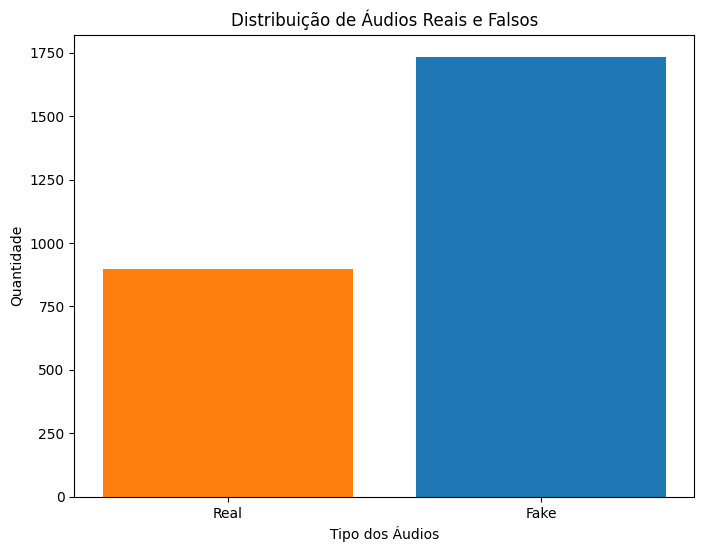

In [ ]:
# Visualizar distribuição dos rótulos
plt.figure(figsize=(8, 6))
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, tick_label=['Fake', 'Real'], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Tipo dos Áudios')
plt.ylabel('Quantidade')
plt.title('Distribuição de Áudios Reais e Falsos')
plt.show()

In [ ]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Modelos para classificação
models = {
    "RandomForest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "LGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31, verbose=-1),
    "DecisionTree": DecisionTreeClassifier(criterion='gini', random_state=42)
}

# Treinar e avaliar modelos
for name, model in models.items():
    print(f"Treinando e avaliando {name}:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precisão: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
    print("-" * 50)

Treinando e avaliando RandomForest:
Acurácia: 0.95
Precisão: 0.94
Recall: 0.99
F1-Score: 0.96
--------------------------------------------------
Treinando e avaliando KNeighbors:
Acurácia: 0.91
Precisão: 0.93
Recall: 0.93
F1-Score: 0.93
--------------------------------------------------
Treinando e avaliando XGBoost:
Acurácia: 0.97
Precisão: 0.97
Recall: 0.98
F1-Score: 0.97
--------------------------------------------------
Treinando e avaliando LGBM:
Acurácia: 0.95
Precisão: 0.96
Recall: 0.98
F1-Score: 0.97
--------------------------------------------------
Treinando e avaliando DecisionTree:
Acurácia: 0.89
Precisão: 0.91
Recall: 0.92
F1-Score: 0.92
--------------------------------------------------
